## Importing Libraries

In [4]:
import os
import pickle
import re
import zipfile
from collections import Counter

import dill
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

### Load Models

In [5]:
# Check for models
try:
    spacy.load('en_core_web_sm')
except LookupError:
    print('Run: python -m spacy download en_core_web_sm')

try:
    nltk_stop = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [6]:
# Initialize spacy model
nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words.update(nltk_stop)

## Data Preprocessing

### Load Data
Local run: download the data from [kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) and the individual zip files in `input` folder.

In [7]:
# Load the dataset into pandas dataframe
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test_labels.csv')
df_testcomments = pd.read_csv('test.csv')

In [8]:
# obtain class labels of the dataset
class_labels = list(df.columns[2:])
class_labels

# remove rows with -1 from df_test as it is not used for scoring
print(f'Before removing -1: {df_test.shape}')
for class_label in class_labels:
    df_test = df_test[df_test[class_label] != -1]
print(f'After removing -1: {df_test.shape}')

# merge df_test and df_testcomments on id
df_test = pd.merge(df_test, df_testcomments, on='id', how='left')
# rearraange columns to be the same as df
df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

Before removing -1: (153164, 7)
After removing -1: (63978, 7)


### Data Preprocessing

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


In [10]:
def preprocess_text(text):
    """
    Take a string as input and performs the following:
    1. Remove extra spaces
    2. Remove “\n”
    3. Remove Non-English characters
    4. Remove start and end white spaces
    5. Remove single characters
    6. Remove punctuations
    7. Lowercase

    :param text: string
    :return: string
    """
    # remove extra spaces
    text = re.sub("\s\s+", " ", text)
    text = text.replace("\n", " ")
    # remove Non-English characters
    text = re.sub(r'[^\x00-\x7F]+', "", text)
    text = text.strip()
    # remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    # remove punctuations
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = text.lower()

    return text

def tokenize_text(documents):
    """
    Take a list of documents as input and performs the following:
    1. Tokenize the documents
    2. Remove stop words and non-alphabetic characters

    Using nlp.pipe to batch process texts and yield Doc objects
        
    :param documents: list of strings
    :return: list of lists of strings
    """
    lemma_list = []
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=1000):
        # Generate lemmatized tokens
        lemmatized_tokens = [token.lemma_ for token in doc]
        # Remove stop words and non-alphabetic characters
        lemmatized_tokens = [token for token in lemmatized_tokens
                             if token not in nlp.Defaults.stop_words
                             and token.isalpha()]
        lemma_list.append(lemmatized_tokens)

    return lemma_list

In [11]:
# Apply preprocessing to train data
df['comment_text'] = df['comment_text'].apply(preprocess_text)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more can t make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [12]:
# Apply preprocessing to test data
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank you for understanding think very highly ...,0,0,0,0,0,0
1,000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0
2,0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0
3,0003e1cccfd5a40a,it says it right there that it is type the ty...,0,0,0,0,0,0
4,00059ace3e3e9a53,before adding new product to the list make su...,0,0,0,0,0,0


In [13]:
# Tokenize train and test data
tokenized_comment = tokenize_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_text(df_test['comment_text'].tolist())

# Get label for train and test data
y = df[class_labels]
y_test = df_test[class_labels]

In [14]:
# combine tokenized data and labels to another dataframe
df_combined = pd.DataFrame({'comment': tokenized_comment,
                            'toxic': y['toxic'],
                            'severe_toxic': y['severe_toxic'],
                            'obscene': y['obscene'],
                            'threat': y['threat'],
                            'insult': y['insult'],
                            'identity_hate': y['identity_hate']})

df_combined_test = pd.DataFrame({'comment': tokenized_comment_test,
                                 'toxic': y_test['toxic'],
                                 'severe_toxic': y_test['severe_toxic'],
                                 'obscene': y_test['obscene'],
                                 'threat': y_test['threat'],
                                 'insult': y_test['insult'],
                                 'identity_hate': y_test['identity_hate']})

df_combined.head()

,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edit, username, hardcore, metall...",0,0,0,0,0,0
1,"[aww, match, background, colour, I, seemingly,...",0,0,0,0,0,0
2,"[hey, man, I, try, edit, war, guy, constantly,...",0,0,0,0,0,0
3,"[real, suggestion, improvement, wonder, sectio...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


## Data Understanding and Analysis
  > Requirement of Task 1
 - Number of sentences and tokens per class.
 - Check for class imbalance.
 - Analyze the most common words for each class - most used terms for each level of toxicity.

In [15]:
def graph_multilabel(df1,
                     title='Number of comments having multiple labels',
                     offset=500):
    """
    Plot number of comments having multiple labels

    :param df1: dataframe
    :param title: string
    :param offset: int
    :return: series
    """

    # sum of all labels
    rowSums = df1.iloc[:, 2:].sum(axis=1)
    # count of comments having multiple labels
    multiLabel_counts = rowSums.value_counts()
    # remove count of comments having zero labels
    multiLabel_counts = multiLabel_counts[1:]
    # sort the index
    multiLabel_counts = multiLabel_counts.sort_index(ascending=True)

    sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)
    for i, v in enumerate(multiLabel_counts.values):
        plt.text(i - 0.2, v + offset, str(v), color='black', fontweight='bold')
    plt.title(title)
    plt.ylabel('Number of comments', fontsize=12)
    plt.xlabel('Number of labels', fontsize=12)
    plt.show()
    return multiLabel_counts


def get_class_info(df, df_combine, class_labels):
    """
    Get number of sentences and tokens for each class

    :param df: dataframe
    :param df_combine: dataframe
    :param class_labels: list of strings
    :return: dictionary
    """
    class_info = {}
    for class_label in class_labels:
        data = df[df[class_label] == 1]
        num_sentences = data.shape[0]
        num_tokens = df_combine[df_combine[class_label]
                                == 1]['comment'].apply(len).sum()
        class_info[class_label] = {
            'num_sentences': num_sentences, 'num_tokens': num_tokens}
    return class_info


def plot_sent(class_info,
              title='Number of sentences per class in training data',
              label_offset=500):
    """
    Plot number of sentences per class

    :param class_info: dictionary
    :param title: string
    :param label_offset: int
    :return: None
    """
    counts = [d['num_sentences'] for d in class_info.values()]
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_labels, y=counts)
    plt.title(title)
    for i, count in enumerate(counts):
        plt.text(i, count + label_offset, count, ha='center', va='top')
    plt.show()


def plot_tokens(class_info,
                title='Number of tokens per class in training data',
                label_offset=500):
    """
    Plot number of tokens per class

    :param class_info: dictionary
    :param title: string
    :param label_offset: int
    :return: None
    """
    counts = [d['num_tokens'] for d in class_info.values()]
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_labels, y=counts)
    plt.title(title)
    for i, count in enumerate(counts):
        plt.text(i, count + label_offset, count, ha='center', va='top')
    plt.show()


def plot_common_words(counts, title):
    """
    Plot most common words

    :param counts: list of tuples
    :param title: string
    :return: None
    """
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, freqs, color='blue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


### Sentences and Tokens per Class and Data Distribution

In [16]:
# count of words per label
category_counts = df.iloc[:, 2:].sum()
print(category_counts)
print('\n')
category_counts_test = df_test.iloc[:, 2:].sum()
print(category_counts_test)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


toxic            6090
severe_toxic      367
obscene          3691
threat            211
insult           3427
identity_hate     712
dtype: int64


- Based on the output of `category_counts` and `category_counts_test` above, we can see that the data is highly imbalanced.
- While data augmentation techniques can be used to balance the data, we will use class weights to balance the data during training.
- Class weights are calculated as the inverse of the class frequency in the training data, per sci-kit learn documentation:
  - Formula: `n_samples / (n_classes * np.bincount(y))`
- Due to the highly imbalanced nature of this dataset, accuracy might not be a good metric for evaluation. Precision, Recall or AUC would be more suitable.
- To be consistent with the evaluation metric of the competition, we will use ROC-AUC as the evaluation metric for our models.

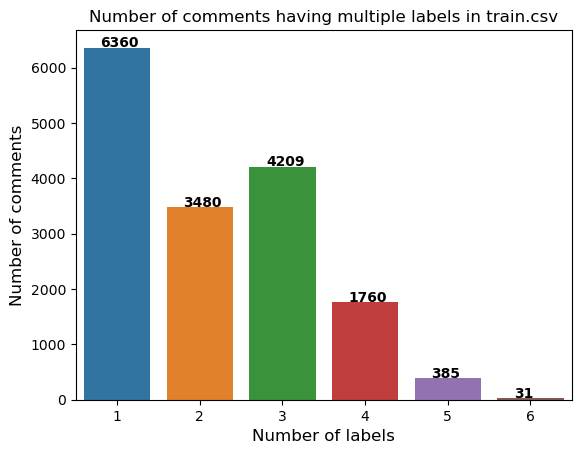

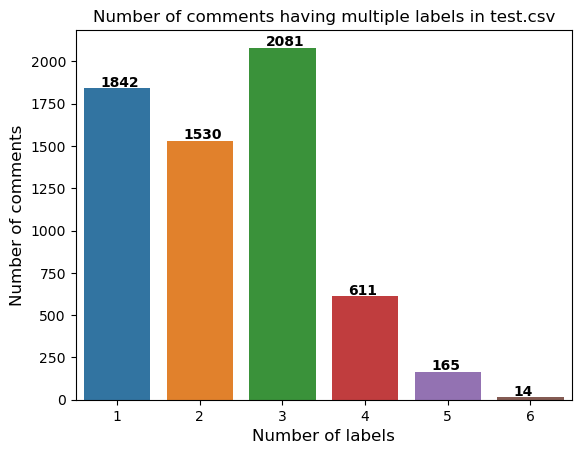

1    1842
2    1530
3    2081
4     611
5     165
6      14
Name: count, dtype: int64

In [17]:
# plot number of comments having multiple labels
label_count = graph_multilabel(df,
                               title='Number of comments having multiple labels in train.csv',
                               offset=10)
graph_multilabel(
    df_test, title='Number of comments having multiple labels in test.csv', offset=10)


As shown above, most toxic comments have multiple labels.

In [18]:
# get number of sentences and tokens for each class
train_info = get_class_info(df, df_combined, class_labels)
train_info

{'toxic': {'num_sentences': 15294, 'num_tokens': 386611},
 'severe_toxic': {'num_sentences': 1595, 'num_tokens': 72476},
 'obscene': {'num_sentences': 8449, 'num_tokens': 214419},
 'threat': {'num_sentences': 478, 'num_tokens': 12904},
 'insult': {'num_sentences': 7877, 'num_tokens': 192976},
 'identity_hate': {'num_sentences': 1405, 'num_tokens': 41801}}

In [19]:
test_info = get_class_info(df_test, df_combined_test, class_labels)
test_info

{'toxic': {'num_sentences': 6090, 'num_tokens': 136061},
 'severe_toxic': {'num_sentences': 367, 'num_tokens': 28292},
 'obscene': {'num_sentences': 3691, 'num_tokens': 93134},
 'threat': {'num_sentences': 211, 'num_tokens': 6429},
 'insult': {'num_sentences': 3427, 'num_tokens': 84253},
 'identity_hate': {'num_sentences': 712, 'num_tokens': 24156}}

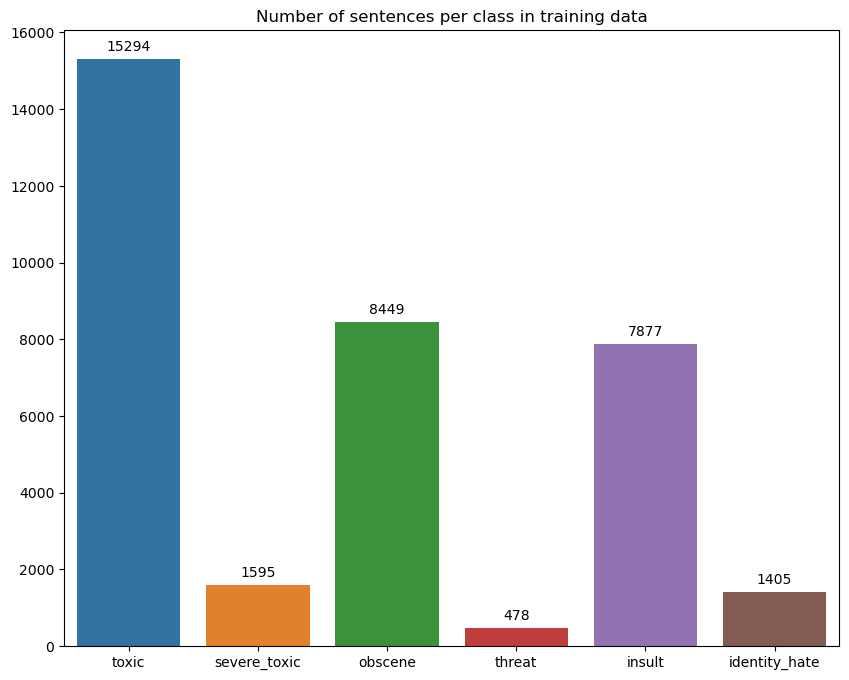

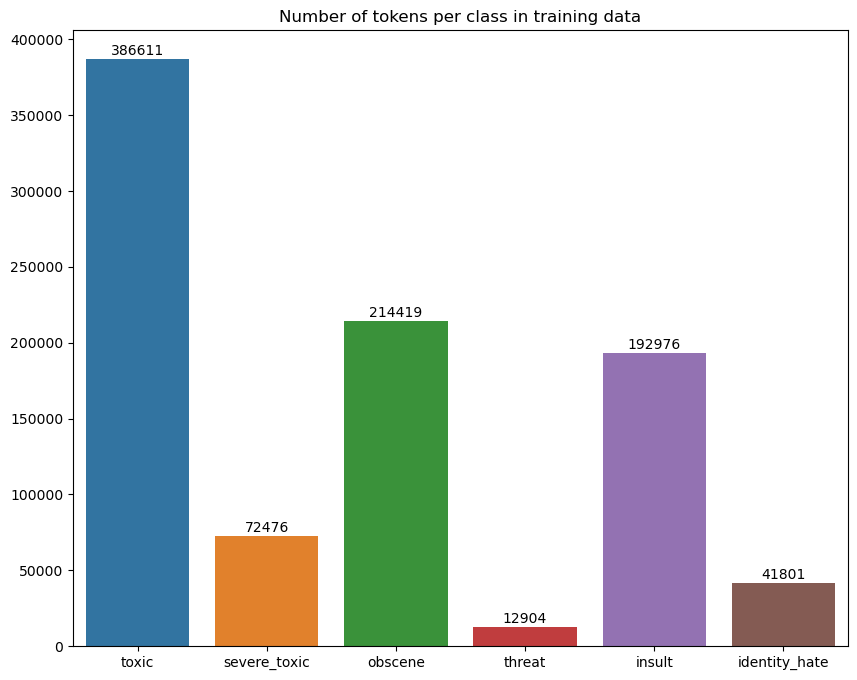

In [20]:
# Visualize the distributtion of the dataset
plot_sent(train_info, title='Number of sentences per class in training data')

# Visualize the distribution of number of tokens per class
plot_tokens(train_info, title='Number of tokens per class in training data', label_offset=10000)

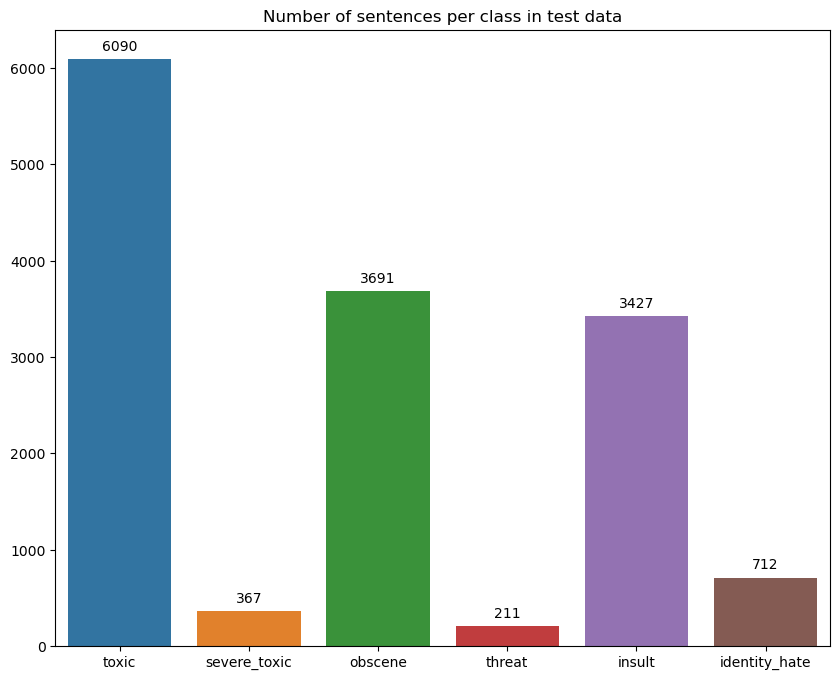

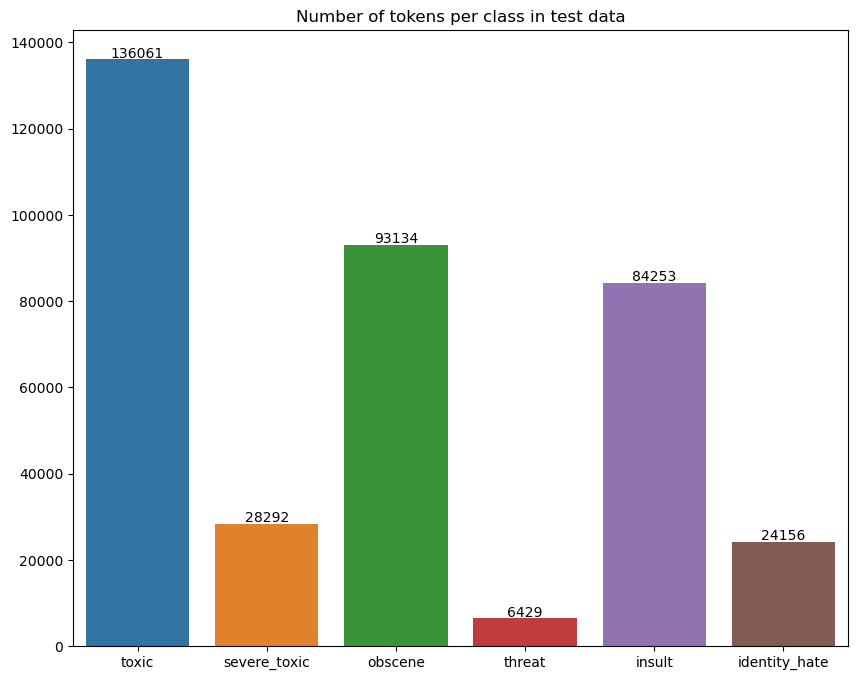

In [21]:
# Visualize the number of sentences per class
plot_sent(test_info, title='Number of sentences per class in test data', label_offset=200)

# Visualize the number of tokens per class
plot_tokens(test_info, title='Number of tokens per class in test data', label_offset=3000)

### Most Common Words per Class

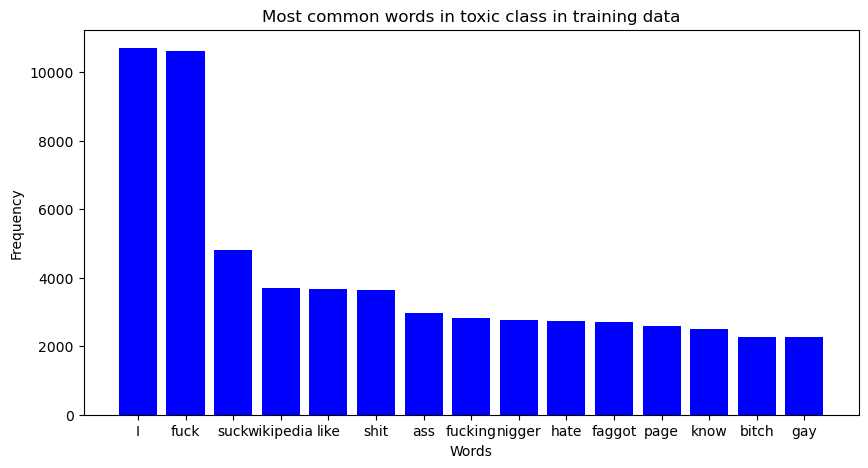

Most common words in toxic class: [('I', 10697), ('fuck', 10624), ('suck', 4801), ('wikipedia', 3688), ('like', 3657), ('shit', 3652), ('ass', 2967), ('fucking', 2822), ('nigger', 2768), ('hate', 2743), ('faggot', 2693), ('page', 2591), ('know', 2492), ('bitch', 2278), ('gay', 2268)]


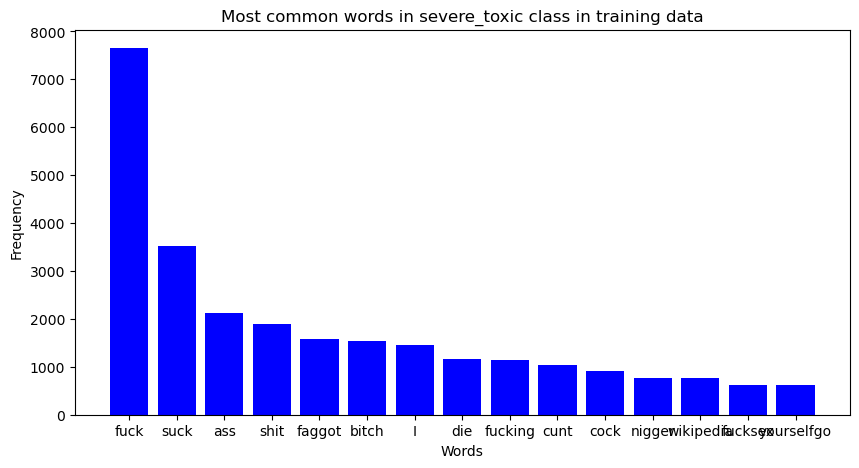

Most common words in severe_toxic class: [('fuck', 7654), ('suck', 3519), ('ass', 2119), ('shit', 1889), ('faggot', 1576), ('bitch', 1544), ('I', 1463), ('die', 1165), ('fucking', 1149), ('cunt', 1038), ('cock', 905), ('nigger', 776), ('wikipedia', 774), ('fucksex', 624), ('yourselfgo', 621)]


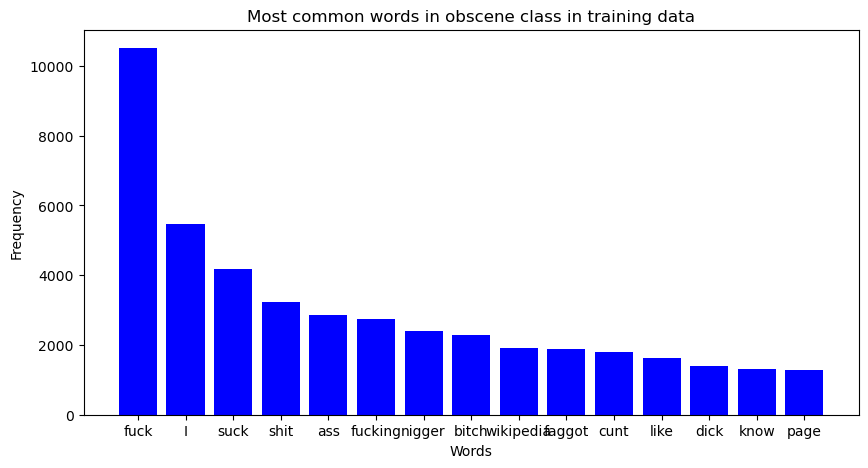

Most common words in obscene class: [('fuck', 10510), ('I', 5470), ('suck', 4191), ('shit', 3234), ('ass', 2869), ('fucking', 2738), ('nigger', 2409), ('bitch', 2281), ('wikipedia', 1912), ('faggot', 1893), ('cunt', 1784), ('like', 1634), ('dick', 1401), ('know', 1300), ('page', 1294)]


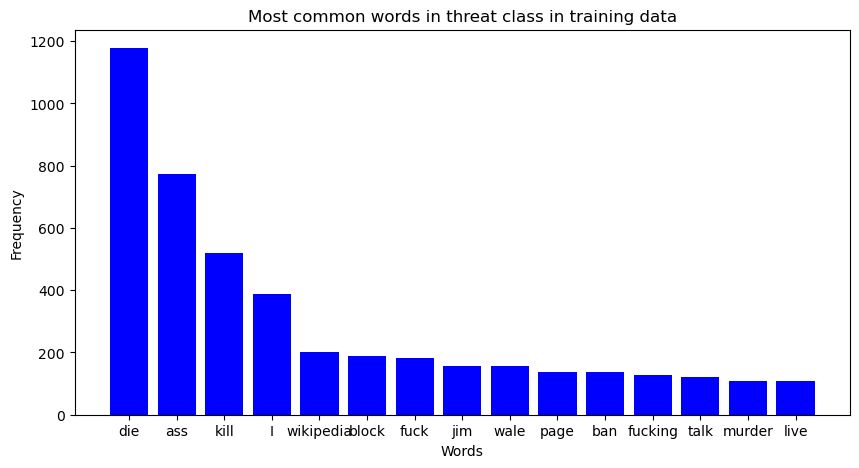

Most common words in threat class: [('die', 1178), ('ass', 772), ('kill', 521), ('I', 388), ('wikipedia', 200), ('block', 188), ('fuck', 183), ('jim', 158), ('wale', 157), ('page', 138), ('ban', 136), ('fucking', 129), ('talk', 121), ('murder', 109), ('live', 107)]


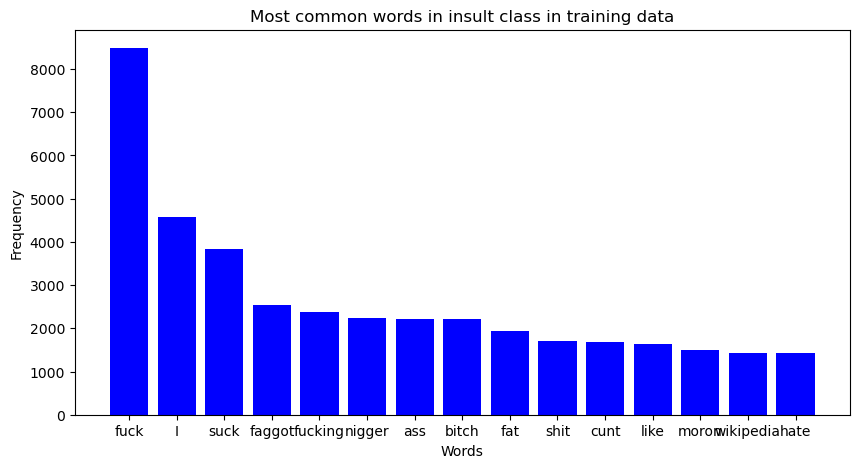

Most common words in insult class: [('fuck', 8486), ('I', 4566), ('suck', 3834), ('faggot', 2532), ('fucking', 2378), ('nigger', 2236), ('ass', 2226), ('bitch', 2209), ('fat', 1928), ('shit', 1709), ('cunt', 1689), ('like', 1644), ('moron', 1507), ('wikipedia', 1433), ('hate', 1430)]


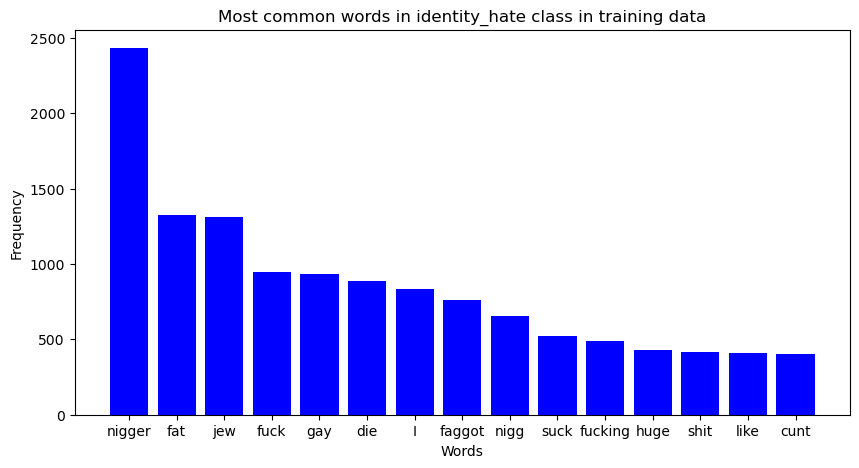

Most common words in identity_hate class: [('nigger', 2433), ('fat', 1323), ('jew', 1314), ('fuck', 946), ('gay', 936), ('die', 885), ('I', 834), ('faggot', 761), ('nigg', 656), ('suck', 520), ('fucking', 491), ('huge', 430), ('shit', 413), ('like', 409), ('cunt', 403)]


In [22]:
# Visualize the distribution of the 15 most common words for each class
for label in class_labels:
    words = []
    for comment in df_combined[df_combined[label] == 1]['comment']:
        words.extend(comment)
    most_common_words = Counter(words).most_common(15)
    plot_common_words(most_common_words, f'Most common words in {label} class in training data')
    print(f'Most common words in {label} class: {most_common_words}')


## Feature Extraction, Model Development and Evaluation
 
 > Requirement of Task 2 and 3

In [23]:
def eval_clf(clf, X_test, y_test, class_labels, name):
    """
    Evaluate classifier performance

    :param clf: classifier
    :param X_test: array
    :param y_test: array
    :param class_labels: list of strings
    :param name: string
    :return: dictionary, array, array
    """
    y_pred = clf.predict(X_test)
    # calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc_roc = roc_auc_score(np.array(y_test), y_pred, average='macro')

    # output performance report
    out_dict = {'model': name, 'accuracy': accuracy, 'precision': precision,
                'recall': recall, 'f1': f1, 'auc_roc': auc_roc}

    # output confusion matrix
    conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

    class_report = classification_report(y_test, y_pred,
                                         target_names=class_labels, zero_division=1)

    return out_dict, class_report, conf_matrix


def plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name):
    """
    Plot multilabel confusion matrix
    
    :param conf_matrix: array
    :param class_labels: list of strings
    :param model_name: string
    :return: None
    """
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for cm, label, ax in zip(conf_matrix, class_labels, axs.flatten()):
        sns.heatmap(cm, annot=True, fmt='d', cmap=None, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(label)

    plt.tight_layout()
    plt.suptitle(f'Multilabel Confusion Matrix ({model_name})', y=1.02)
    plt.show()

### TF-IDF Vectorization

In [24]:
# As we've already tokenized the text during data preprocessing
# the tokenizer and preprocessing steps are identity functions
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)

# fit vectorizer on train and test data
X = vectorizer.fit_transform(df_combined['comment'])
X_test = vectorizer.transform(df_combined_test['comment'])

y = df_combined[class_labels]
y_test = df_combined_test[class_labels]

C:\Users\User\AppData\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
# Save vectorizer
with open('tfidf-vectorizer.dill', 'wb') as f:
    dill.dump(vectorizer, f)

In [28]:
X.shape, y.shape, X_test.shape, y_test.shape

((159571, 150754), (159571, 6), (63978, 150754), (63978, 6))

#### Model Development
- As this task is a multi-label classification problem, we will use a classifiers wrapped in a OneVsRestClassifier wrapper.
- The models selected are logistic regression, linear support vector machine and decision tree, as these models are fast to train, and have been shown to perform well in multi-label classification tasks (Graham-Kalio et al., 2021).
  - doi:10.1109/SEGAH52098.2021.9551908

In [29]:
# Initialize the classifiers
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

# Train and test models
init_classifiers = {'SVM': svm, 'LogReg': logreg, 'DecisionTree': dt}
classifiers = {}

metrics = []
class_reports = {}
conf_matrices = {}

for key, classifier in init_classifiers.items():
    classifiers[key] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    out_dict, class_report, conf_matrix = eval_clf(classifiers[key], X_test, y_test, class_labels, key)
    metrics.append(out_dict)
    class_reports[key] = class_report
    conf_matrices[key] = conf_matrix

#### Model Evaluation

In [30]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

          model  accuracy  precision    recall        f1   auc_roc
0           SVM  0.817484   0.345288  0.755909  0.464604  0.854966
1        LogReg  0.799134   0.290021  0.887326  0.421616  0.912718
2  DecisionTree  0.781315   0.252216  0.657783  0.354066  0.799359


In [31]:
# Assign the best model for tfidf
best_model_tfidf = classifiers['LogReg'] # has the best auc_roc score

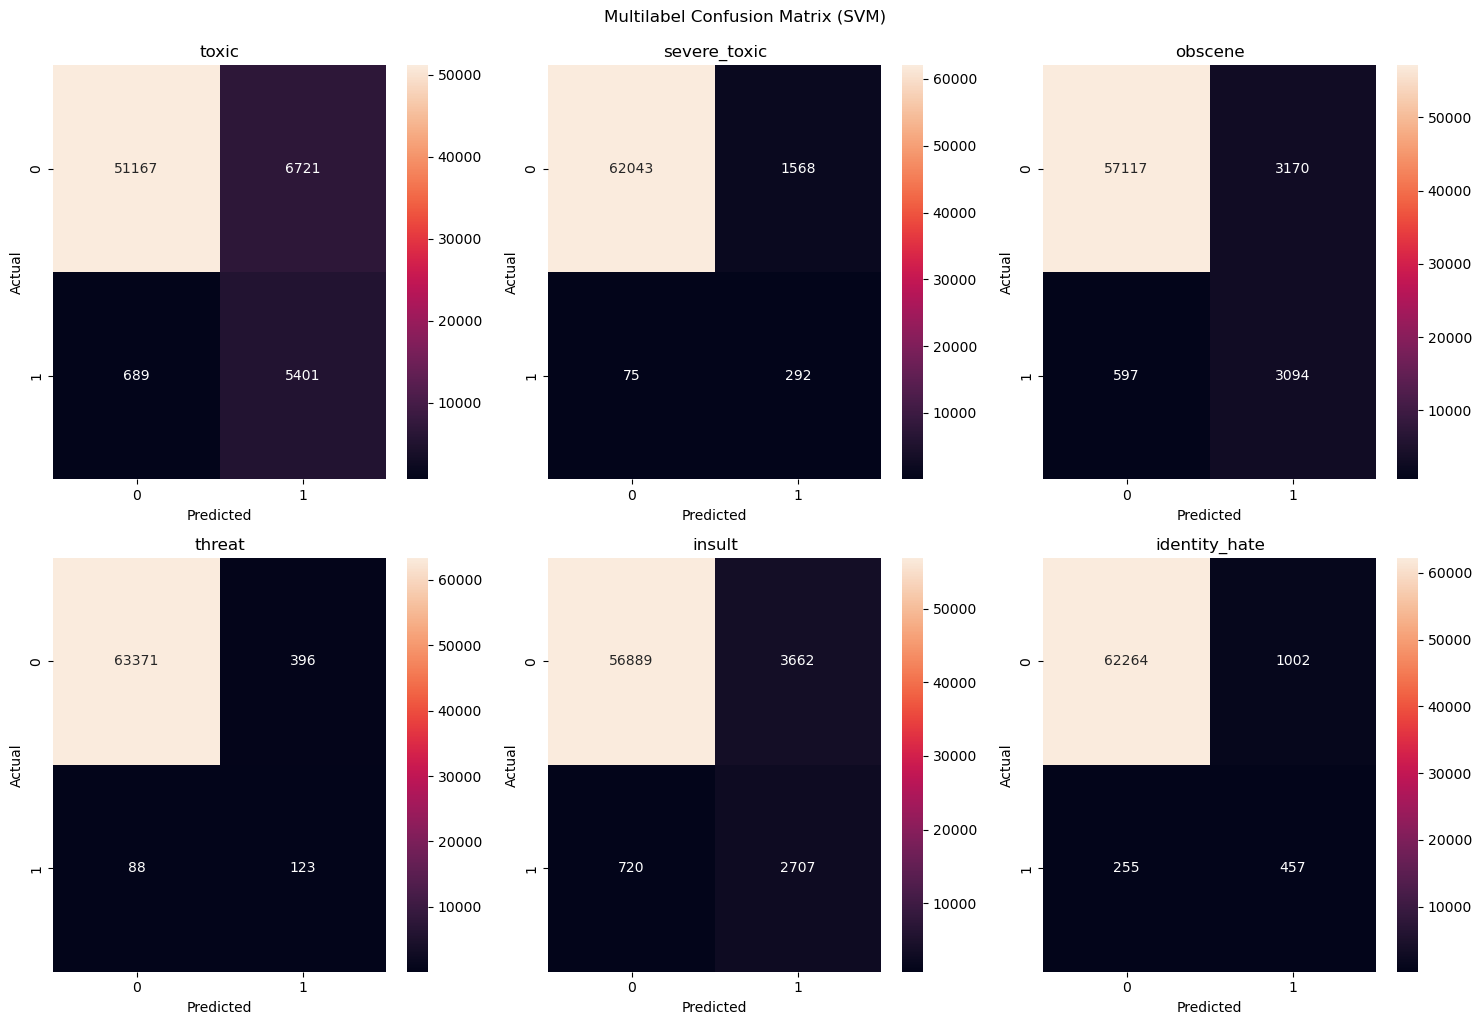

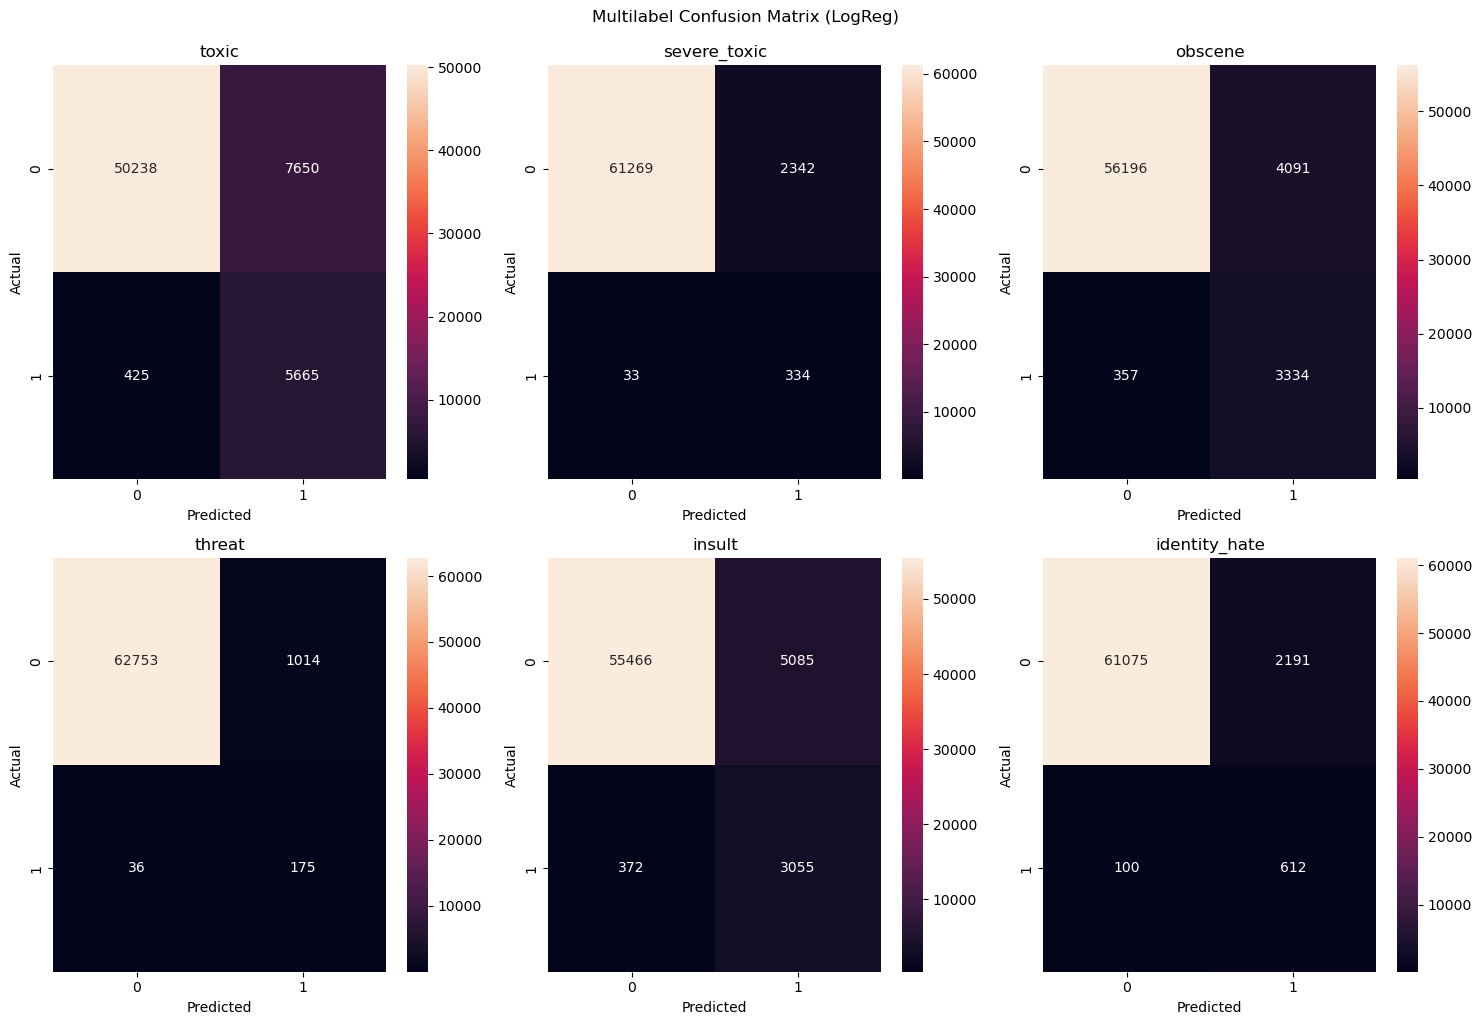

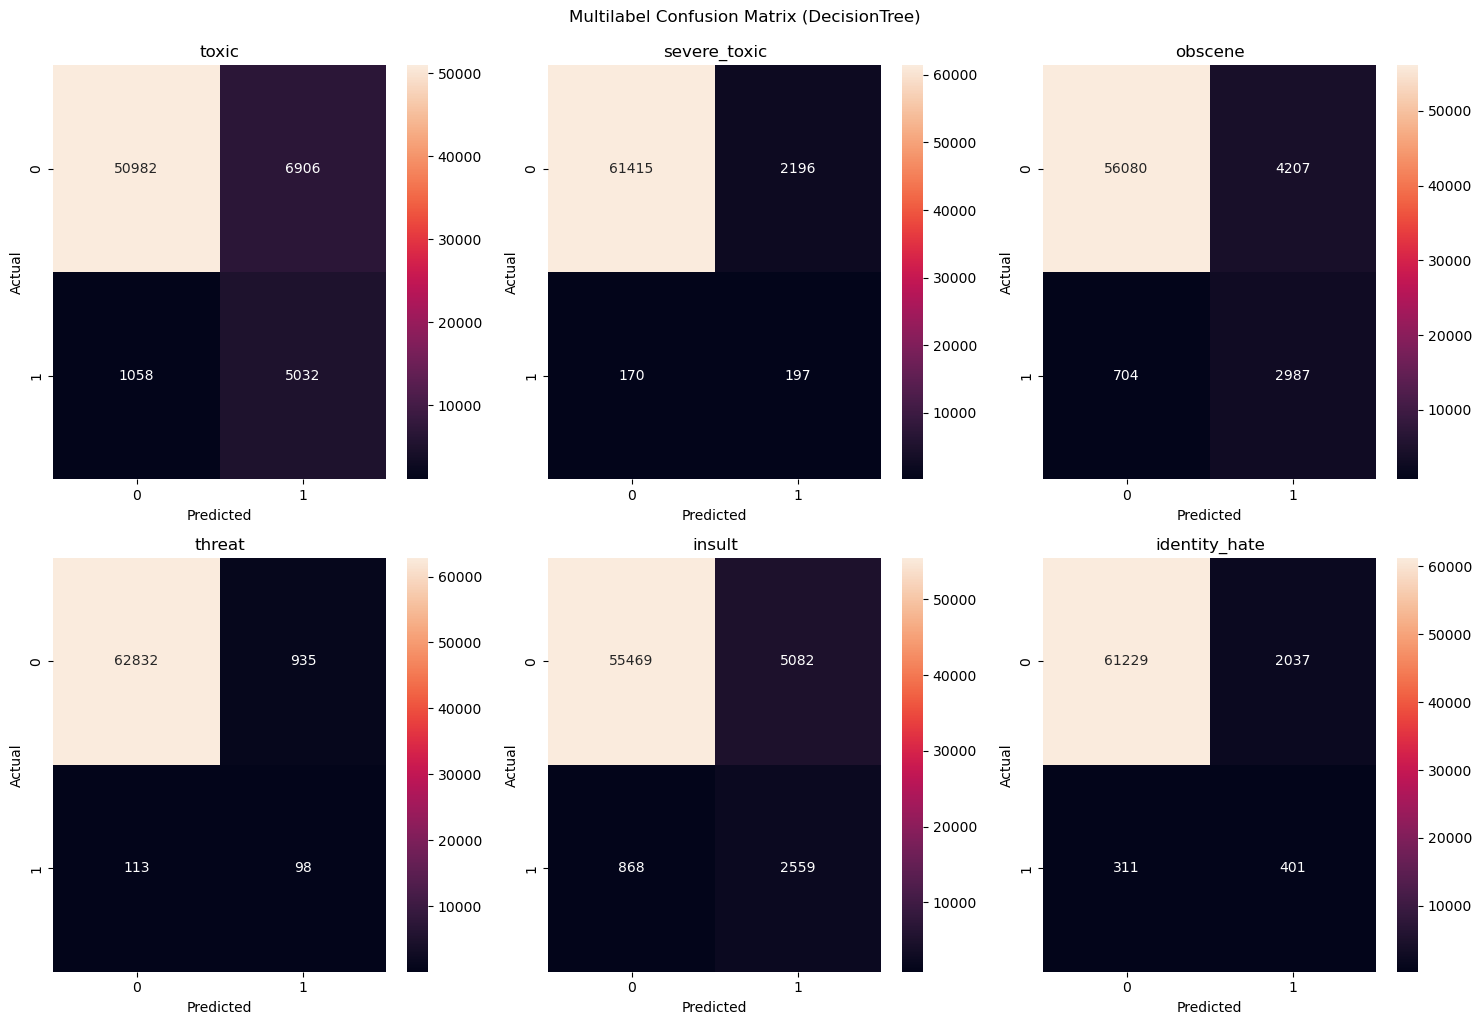

In [32]:
# Plot confusion matrix for each model
for model_name, conf_matrix in conf_matrices.items():
    plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name)

### Word Embeddings vectorization

In [33]:
# Similarly, the tokenized text is used as input to word2vec model
comments = df_combined['comment'].tolist()
comments_test = df_combined_test['comment'].tolist()

y = df_combined[class_labels]
y_test = df_combined_test[class_labels]

In [36]:
# Train word2vec model
model = Word2Vec(sentences=comments, workers=12)
model.save('w2v.model')
word_vectors = model.wv

In [37]:
def get_document_vector(document_tokens):
    """
    Get document vector by averaging word vectors

    :param document_tokens: list of strings
    :return: array
    """
    document_vector = np.zeros((model.vector_size,))
    n_words = 0
    for token in document_tokens:
        if token in model.wv.key_to_index:
            document_vector += model.wv.get_vector(token)
            n_words += 1
    if n_words > 0:
        document_vector /= n_words # get average
    return document_vector

In [38]:
document_vectors_train = [get_document_vector(doc) for doc in comments]
X = np.array(document_vectors_train)

document_vectors_test = [get_document_vector(doc) for doc in comments_test]
X_test = np.array(document_vectors_test)

In [39]:
# Normalize the data for faster processing
X = normalize(X)
X_test = normalize(X_test)

In [40]:
X.shape, y.shape, X_test.shape, y_test.shape


((159571, 100), (159571, 6), (63978, 100), (63978, 6))

#### Model Development
 - Same as above for comparison.

In [41]:
# Initialize the classifiers
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

# Train and test models
init_classifiers = {'SVM': svm, 'LogReg': logreg, 'DecisionTree': dt}
classifiers = {}

metrics = []
class_reports = {}
conf_matrices = {}

for key, classifier in init_classifiers.items():
    classifiers[key] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    out_dict, class_report, conf_matrix = eval_clf(classifiers[key], X_test, y_test, class_labels, key)
    metrics.append(out_dict)
    class_reports[key] = class_report
    conf_matrices[key] = conf_matrix

#### Model Evaluation

In [42]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

          model  accuracy  precision    recall        f1   auc_roc
0           SVM  0.739207   0.187484  0.917472  0.286520  0.898097
1        LogReg  0.737378   0.186112  0.919843  0.285221  0.898638
2  DecisionTree  0.822736   0.317832  0.400052  0.350103  0.686017


In [43]:
best_model_w2v = classifiers['SVM'] # has the best auc_roc score

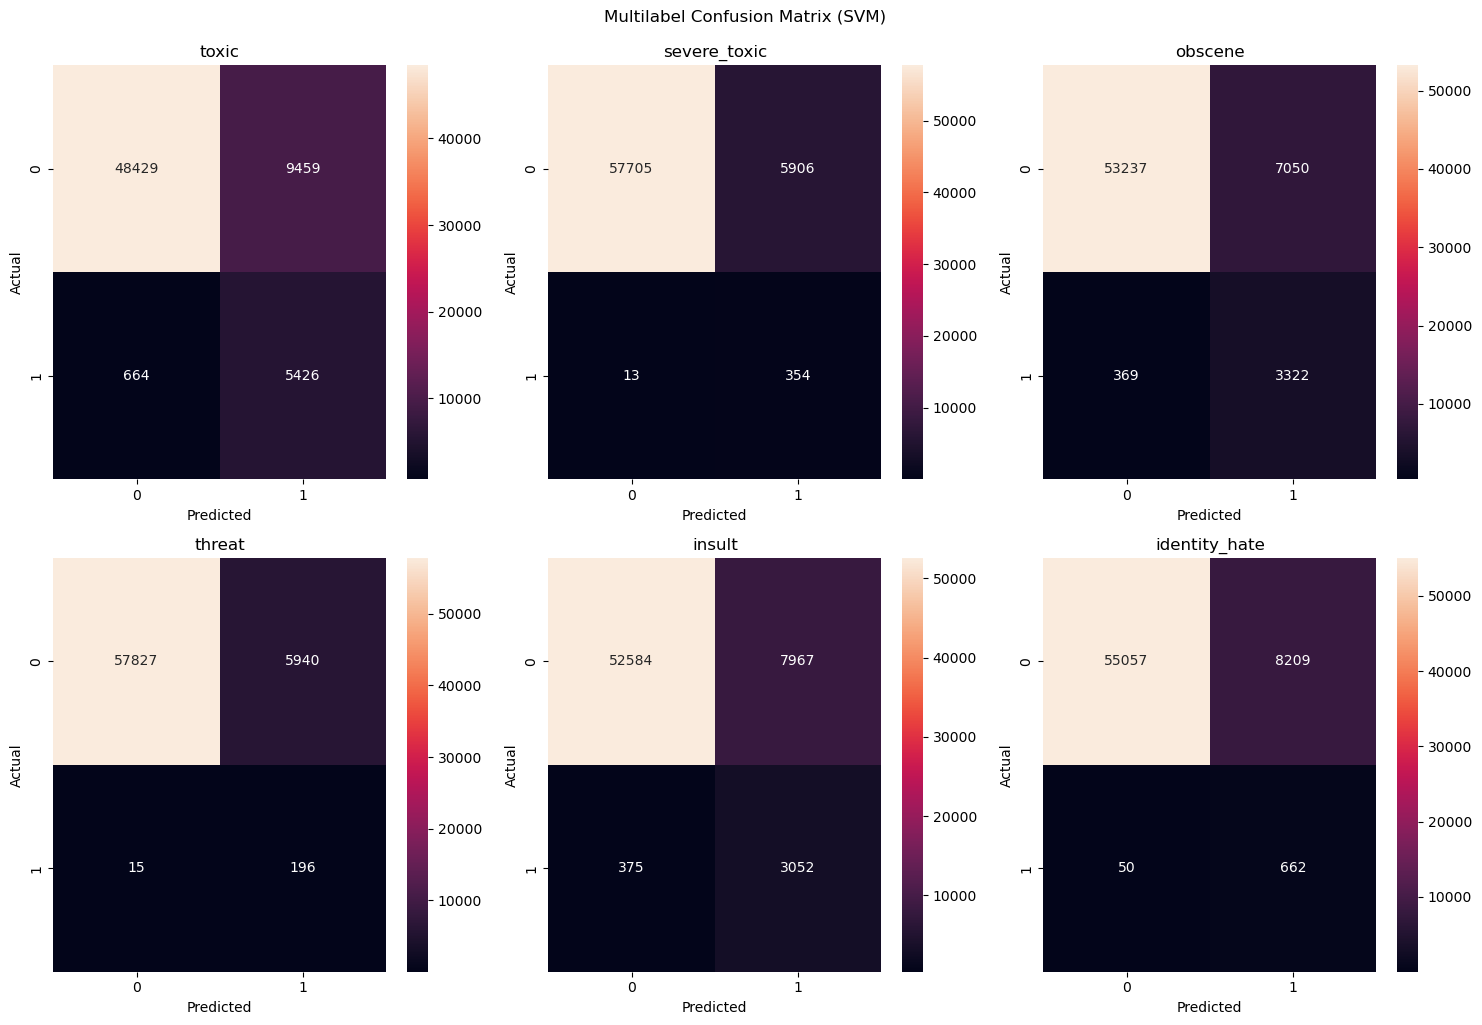

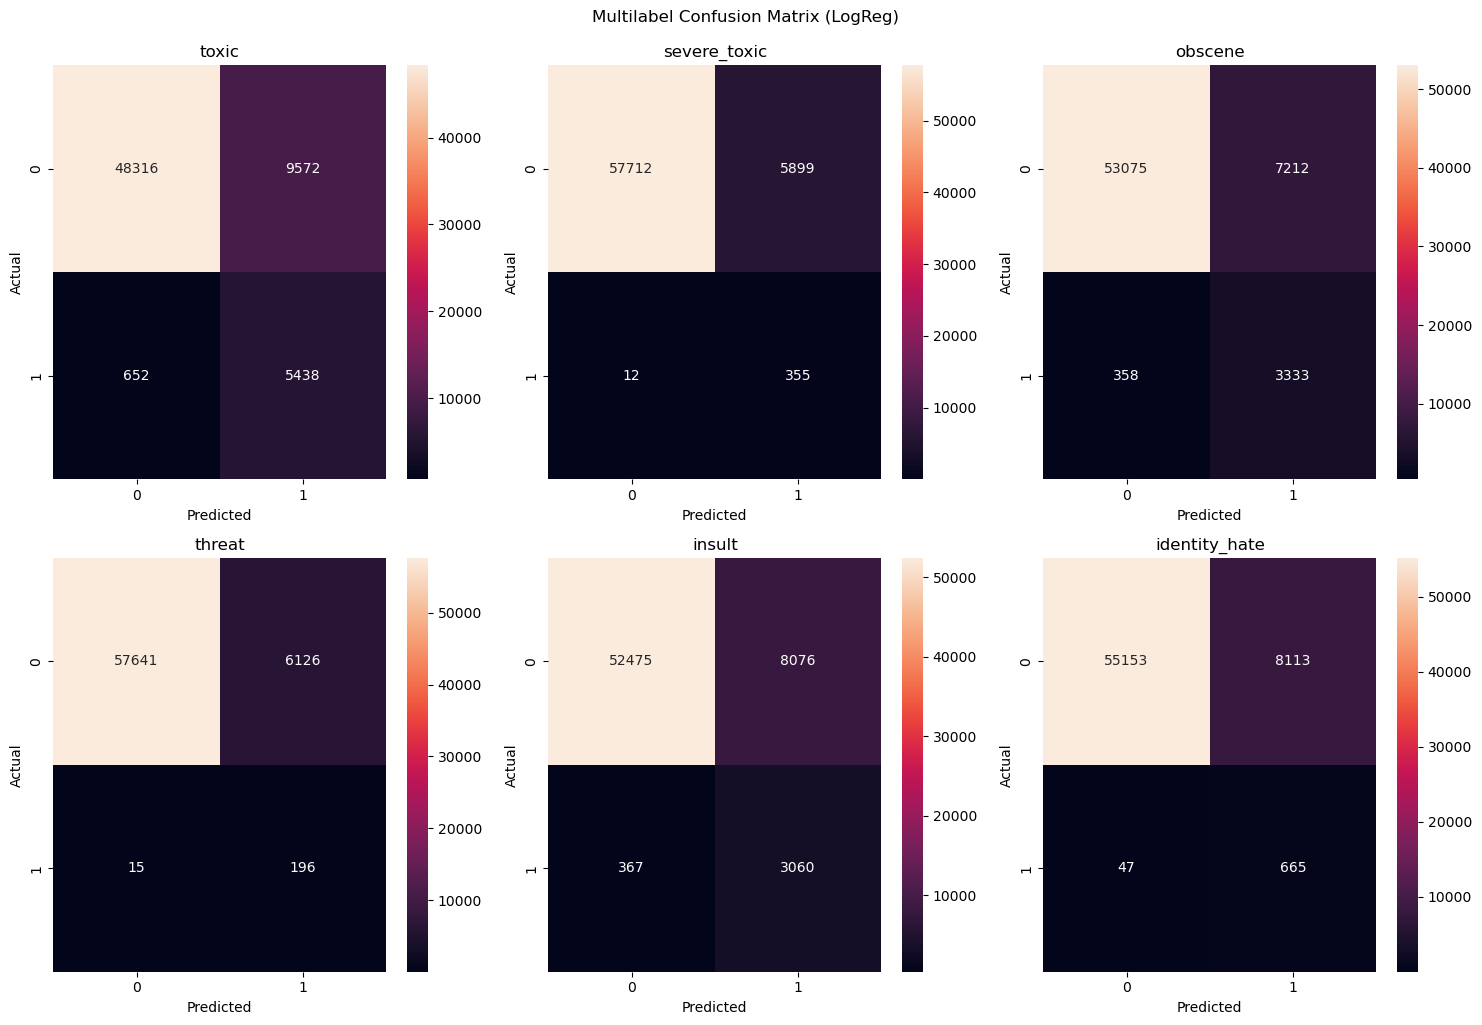

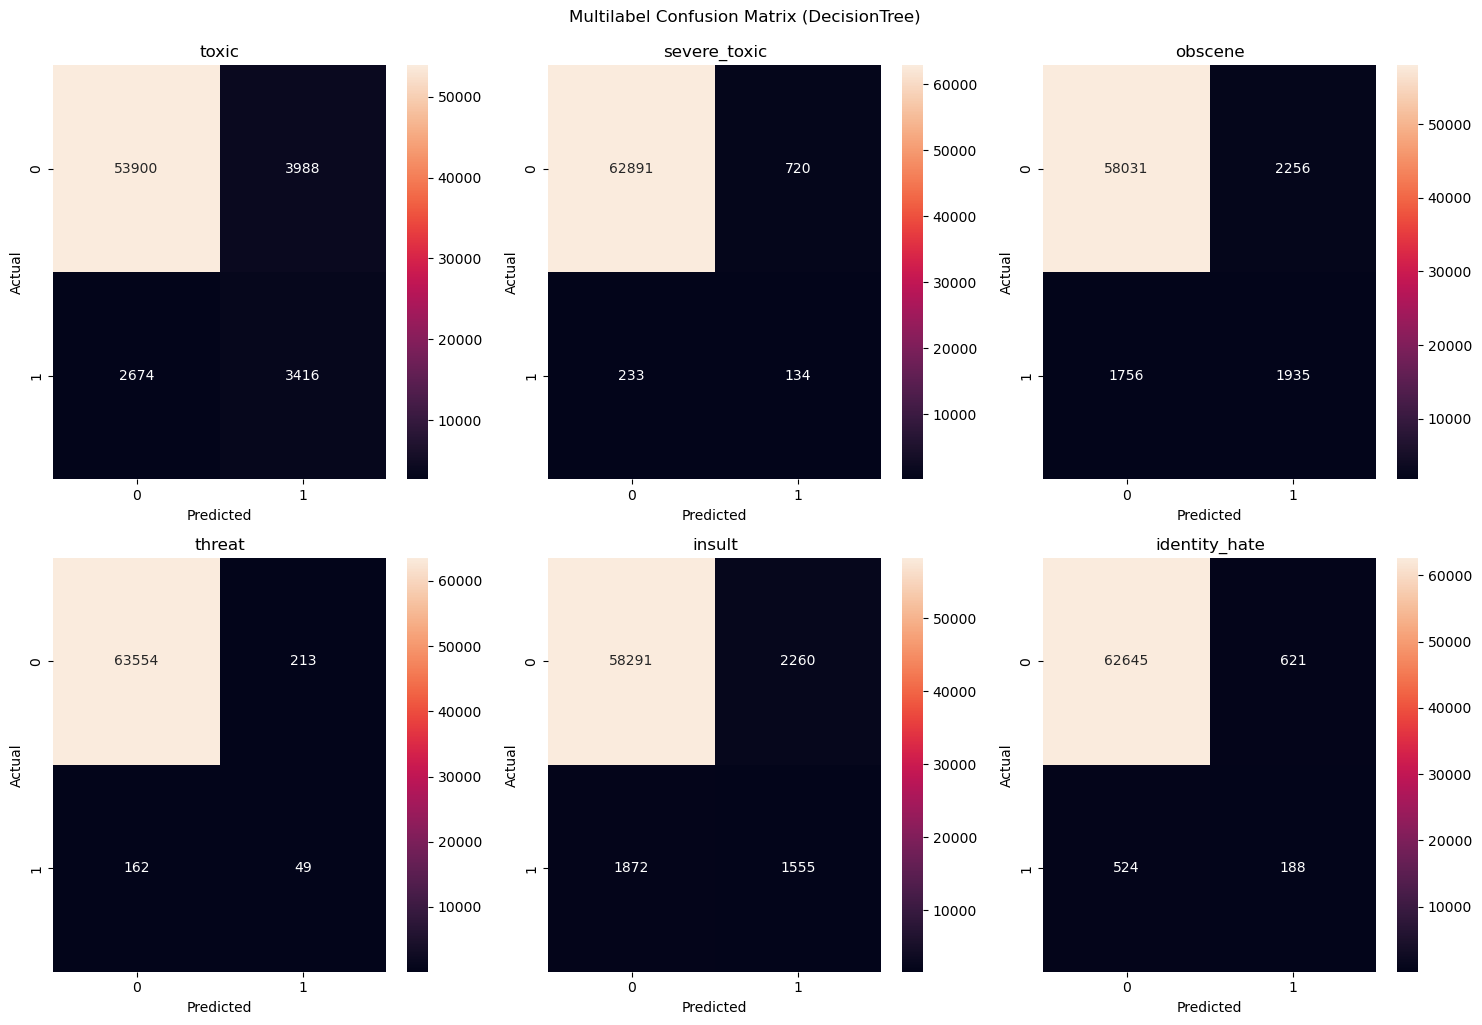

In [44]:
# Plot confusion matrix for each model
for model_name, conf_matrix in conf_matrices.items():
    plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name)

## Conclusion

In [46]:
# save the best model
best_model = best_model_tfidf
pickle.dump(best_model, open('best_model.pkl', 'wb'))

- The results showed that the choice of feature extraction method did indeed impact the classification performance.
- The TF-IDF method performed well with all three classifiers, providing reasonably high accuracy, F1-score, recall, precision, and AUC.
- On the other hand, Word Embeddings showed slightly lower performance across the metrics.
- These findings suggest that the selection of the appropriate feature extraction method can significantly affect the classification accuracy and the ability of the models to capture the underlying patterns in the data.